#Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


##Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [ ]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


In [ ]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

What happens varying the ENCODING_DIM? test  and discuss the results in a new cell after the following one.

Change the "ENCODING_DIM" variable will change the amount of compression in each example. As we can see from the below images, increasing this variable implies a smaller amount of compression while if we decrease it we will have more compression. If we choose 784 as value for this variable (equal to the number of column of X matrix) there will be no compression at all and the image will be the same, as we can see from the last image. Of course in this case the training and test mse error is equal to zero. Another thing is that, if we choose  a number too small for this variable, is very difficult to understand, from the compressed image, what was the number the original image was referring to, for example in the case of ENCODING_DIM equal to 10 or 20.


Encoding dimension: 10
training mse: 0.03460
test mse: 0.03420


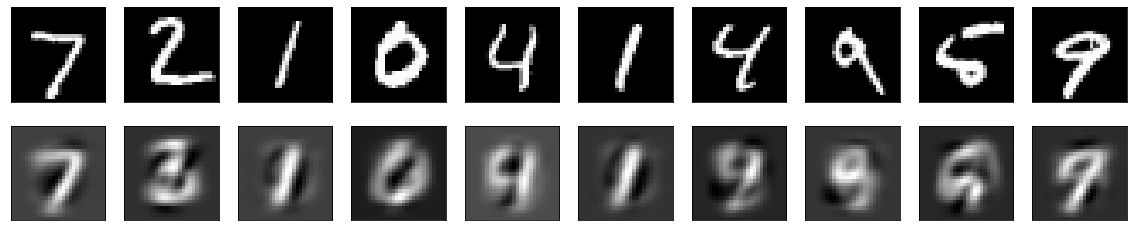

Encoding dimension: 20
training mse: 0.02405
test mse: 0.02356


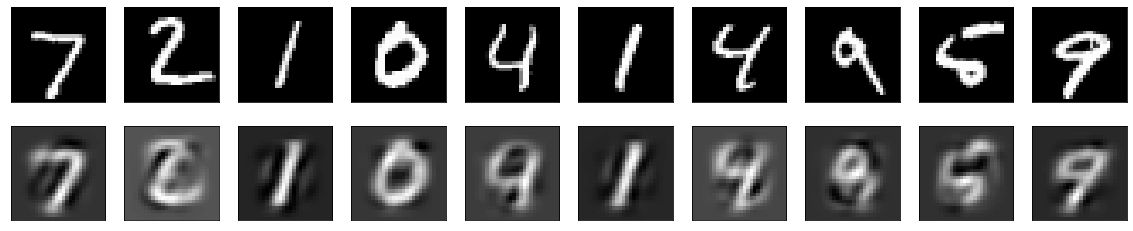

Encoding dimension: 40
training mse: 0.01443
test mse: 0.01405


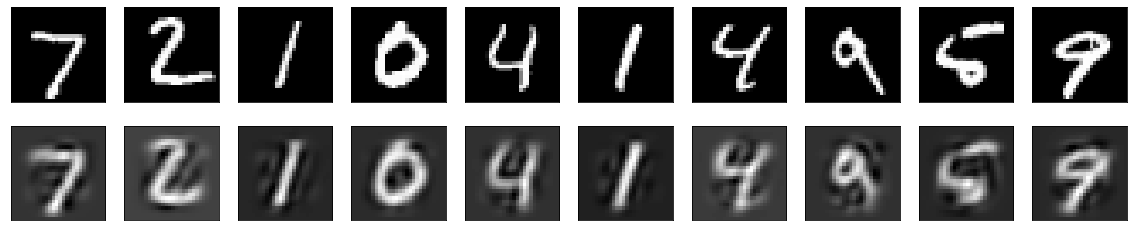

Encoding dimension: 120
training mse: 0.00464
test mse: 0.00455


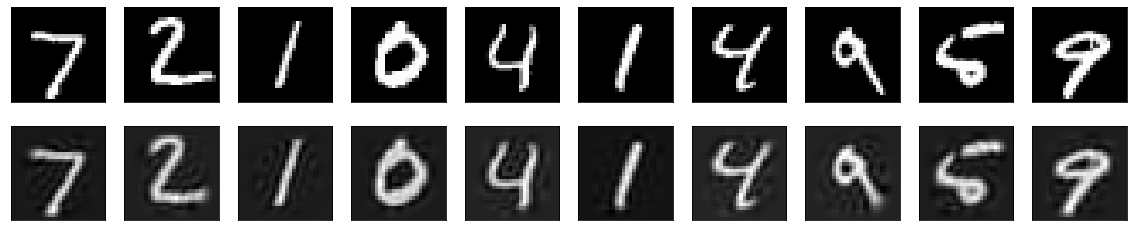

Encoding dimension: 250
training mse: 0.00147
test mse: 0.00146


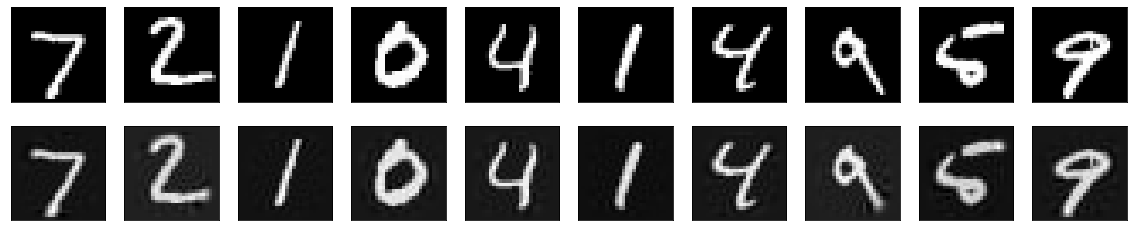

Encoding dimension: 784
training mse: 0.00000
test mse: 0.00000


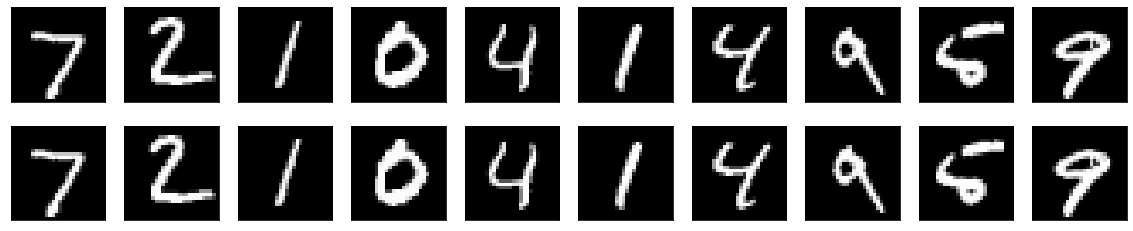

In [ ]:
ENCODING_DIM = [10, 20, 40, 120, 250, 784]

for enc_dim in ENCODING_DIM:
  U_k = svd_k(x_train, enc_dim)
  x_training_pca = np.dot(x_train, U_k)
  x_test_pca = np.dot(x_test, U_k)
  x_training_reco = np.dot(x_training_pca, U_k.T)
  x_test_reco = np.dot(x_test_pca, U_k.T)
  accuracy_train = ((x_train - x_training_reco)**2).mean()
  accuracy_test = ((x_test - x_test_reco)**2).mean()
  print("Encoding dimension: {}".format(enc_dim))
  print("training mse: %.5f" % ( accuracy_train))
  print("test mse: %.5f" % ( accuracy_test))
  plot_img(10, x_test, x_test_reco)


## Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

Check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 3s 24ms/step - loss: 0.0814 - val_loss: 0.0144
Epoch 2/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0125 - val_loss: 0.0089
Epoch 3/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0082 - val_loss: 0.0068
Epoch 4/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 5/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 6/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 7/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 9/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0048
test mse: 0.00478


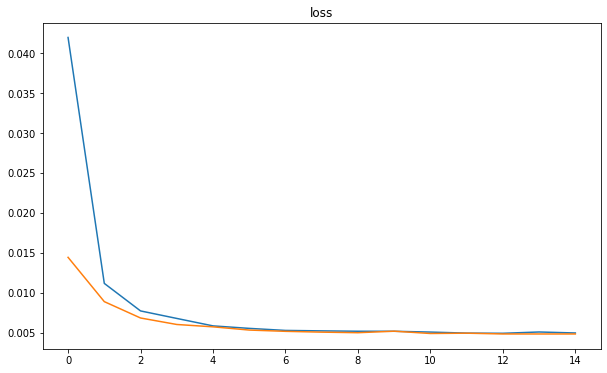

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

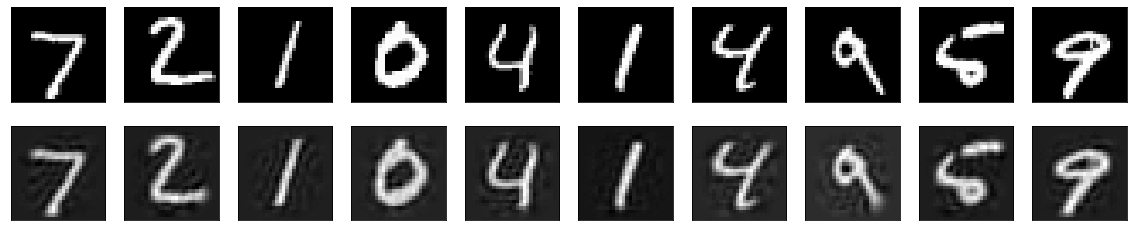

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


Answer:

I'm just considering the case with the encoding dimension of 120. The two models produce approximately the same results, both from the visual point of view of the reconstructed images and also as regards the mean square error (0.00478 for Shallow Linear Autoencoder vs 0.00455 for SVD). This is because the Shallow Linear Autoencoder is basically doing the Singular Value Decomposition (SVD) to compute an orthogonal basis (the principal directions with more variance in the data). So the two model are appling in 'different way' the same methods to reduce the dimensionality of the input space, in this case the images.


## Shallow non-linear autoencoders

Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. (Insert your code and  theoretical discussion into  cells immediately below this one.)


I have chosen empirically the best activaction function. I built three different model with different activaction function and after I compare them in order to choose the best one. In this case the best one is the 'sigmoid'. This model and the previous one have very similar test mse but in the non-linear case the reconstructed image has an higher contrast, basically the background is darker, and also the original images have this characteristic so, in my opinion, the non-linear autoencoders reconstruct better the original image.

Epoch 1/15
98/98 [==============================] - 2s 22ms/step - loss: 0.0752 - val_loss: 0.0352
Epoch 2/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0317 - val_loss: 0.0225
Epoch 3/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0208 - val_loss: 0.0162
Epoch 4/15
98/98 [==============================] - 2s 23ms/step - loss: 0.0154 - val_loss: 0.0128
Epoch 5/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0122 - val_loss: 0.0106
Epoch 6/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 7/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0088 - val_loss: 0.0081
Epoch 8/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0079 - val_loss: 0.0073
Epoch 9/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 10/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 11/

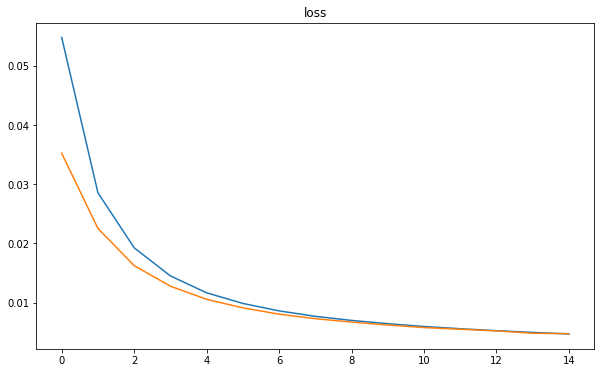

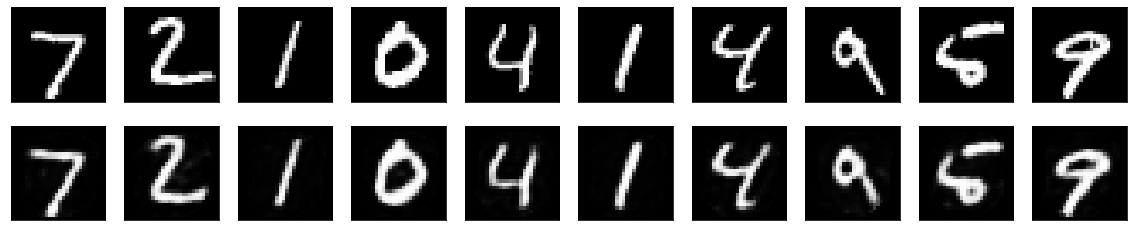

Epoch 1/15
98/98 [==============================] - 2s 22ms/step - loss: 0.0675 - val_loss: 0.0167
Epoch 2/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0150 - val_loss: 0.0113
Epoch 3/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 4/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 5/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 6/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 7/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 8/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 9/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 10/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 11/

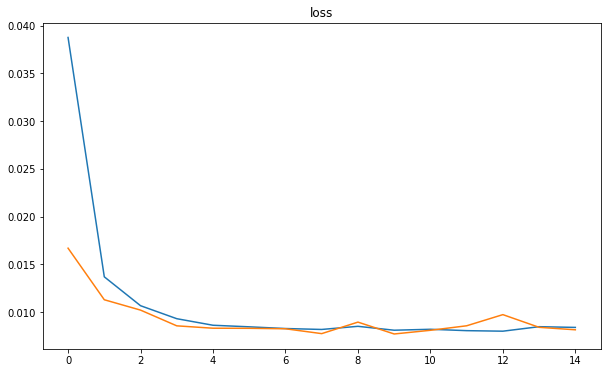

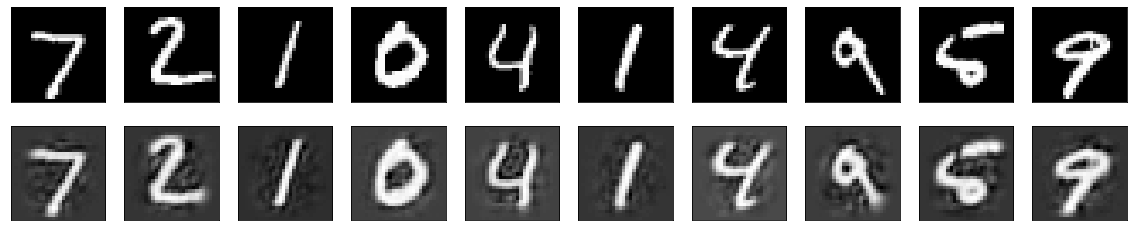

Epoch 1/15
98/98 [==============================] - 3s 23ms/step - loss: 0.0438 - val_loss: 0.0138
Epoch 2/15
98/98 [==============================] - 2s 22ms/step - loss: 0.0129 - val_loss: 0.0113
Epoch 3/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 4/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 5/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0107 - val_loss: 0.0116
Epoch 6/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 7/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 8/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 9/15
98/98 [==============================] - 2s 22ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 10/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 11/

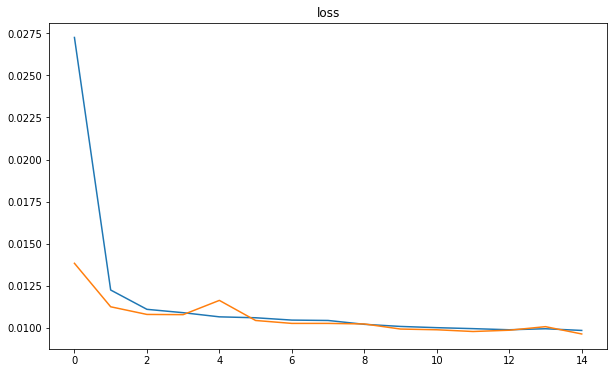

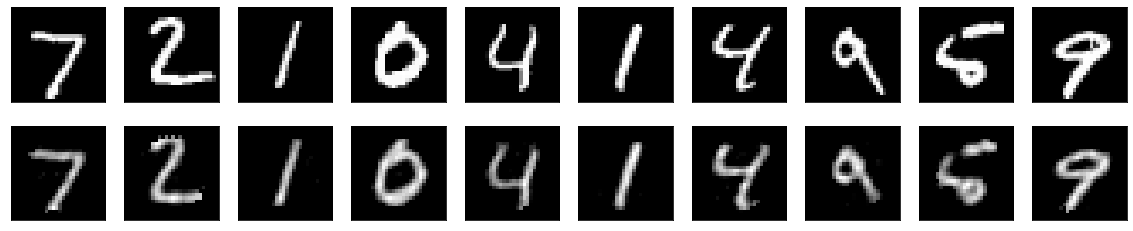

In [ ]:
ENCODING_DIM = 120
activations = ['sigmoid', 'tanh', 'relu'] 
#evolution_act = []

for act in activations:
  input_img = tf.keras.layers.Input(shape=(784,))
  #Define the encoder...
  encoded = tf.keras.layers.Dense(ENCODING_DIM, activation=act)(input_img)

  #...and the decoder...
  decoded = tf.keras.layers.Dense(784, activation=act)(encoded)

  #and finally the autoencoder
  autoencoder = tf.keras.models.Model(input_img, decoded)

  # In order to visualize the learned encoding, define a model that computes the 
  # two parts separately.
  encoder = tf.keras.models.Model(input_img, encoded)
  encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
  decoder_layer = autoencoder.layers[-1]
  decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

  #Finally, let's call the compile method
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
  history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
  plot_loss(history)

  scores = autoencoder.evaluate(x_test, x_test, verbose=2)
  print("test mse {}: {:.5f}".format(act,scores))
  encoded_imgs = encoder.predict(x_test)
  decoded_imgs = decoder.predict(encoded_imgs)

  plot_img(10, x_test, decoded_imgs)


## Deep Autoencoder
Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
input_img = tf.keras.layers.Input(shape=(784,))

#Encoder 784->512->256->128->64
encoded = tf.keras.layers.Dense(512, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)

#Dencoder 128->256->512->784
decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_img, decoded)


autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_13 (Dense)             (None, 256)               330

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 50, batch_size= 256, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/50
196/196 [==============================] - 10s 47ms/step - loss: 0.0861 - val_loss: 0.0309
Epoch 2/50
196/196 [==============================] - 9s 48ms/step - loss: 0.0277 - val_loss: 0.0205
Epoch 3/50
196/196 [==============================] - 9s 48ms/step - loss: 0.0194 - val_loss: 0.0166
Epoch 4/50
196/196 [==============================] - 9s 48ms/step - loss: 0.0160 - val_loss: 0.0142
Epoch 5/50
196/196 [==============================] - 9s 48ms/step - loss: 0.0138 - val_loss: 0.0124
Epoch 6/50
196/196 [==============================] - 9s 47ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 7/50
196/196 [==============================] - 9s 47ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 8/50
196/196 [==============================] - 9s 46ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 9/50
196/196 [==============================] - 9s 47ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 10/50
196/196 [==============================] - 9s 46ms/step - loss: 0.0091 - val_l

313/313 - 2s - loss: 0.0049
test mse: 0.00487


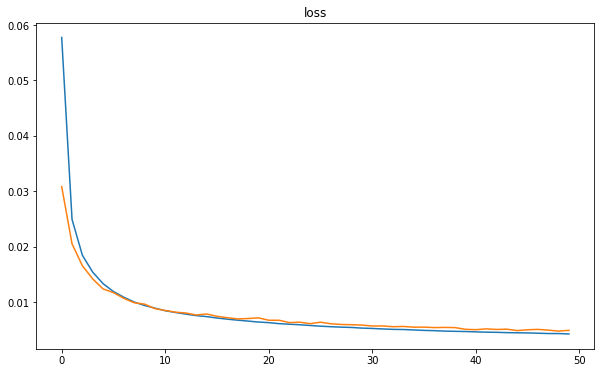

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

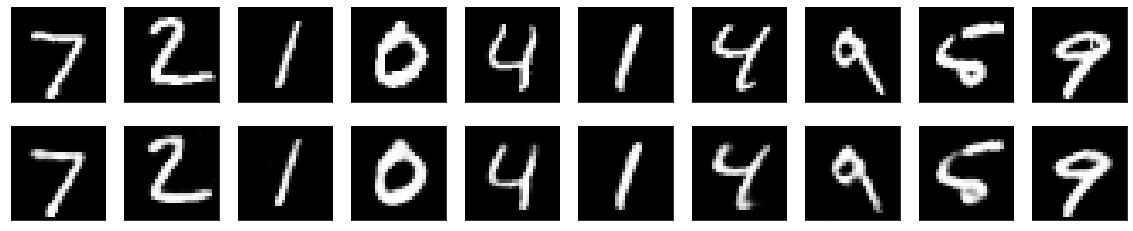

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.
**NOTE: in the code at the bottom noise_factor is added and not multiplied for numerical reasons. You may want to try the version with multiplication to verify it is more unstable.**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

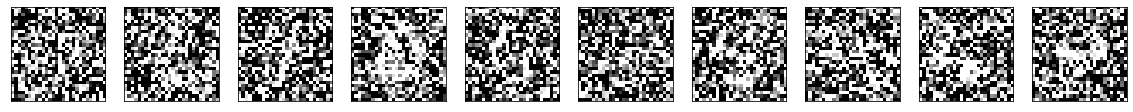

In [ ]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [ ]:
# I re-use the autoencoder defined in Exercise 5.3
input_img = tf.keras.layers.Input(shape=(784,))
# Encoder
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation=act)(input_img)

# Decoder
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

# Autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_17 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs = 50, batch_size=256, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/50
196/196 [==============================] - 3s 14ms/step - loss: 0.0724 - val_loss: 0.0451
Epoch 2/50
196/196 [==============================] - 2s 13ms/step - loss: 0.0438 - val_loss: 0.0418
Epoch 3/50
196/196 [==============================] - 2s 13ms/step - loss: 0.0412 - val_loss: 0.0414
Epoch 4/50
196/196 [==============================] - 2s 13ms/step - loss: 0.0407 - val_loss: 0.0410
Epoch 5/50
196/196 [==============================] - 2s 13ms/step - loss: 0.0405 - val_loss: 0.0406
Epoch 6/50
196/196 [==============================] - 2s 13ms/step - loss: 0.0403 - val_loss: 0.0409
Epoch 7/50
196/196 [==============================] - 2s 12ms/step - loss: 0.0404 - val_loss: 0.0404
Epoch 8/50
196/196 [==============================] - 2s 12ms/step - loss: 0.0403 - val_loss: 0.0405
Epoch 9/50
196/196 [==============================] - 2s 12ms/step - loss: 0.0401 - val_loss: 0.0403
Epoch 10/50
196/196 [==============================] - 2s 12ms/step - loss: 0.0400 - val_lo

313/313 - 0s - loss: 0.0389
test mse: 0.03889


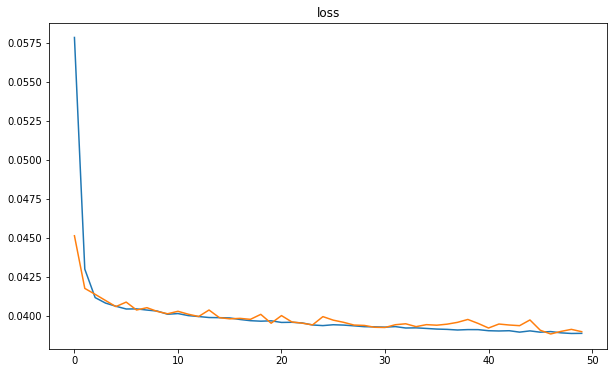

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

Check the result by plotting some input images and the corresponding denoised outputs.

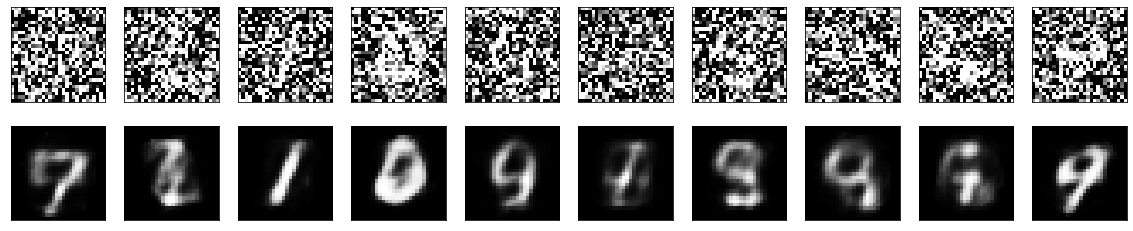

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


1646592/1641221 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 8s 92ms/step - loss: 0.4901 - categorical_accuracy: 0.0244 - val_loss: 0.1131 - val_categorical_accuracy: 0.1956
Epoch 2/50
79/79 [==============================] - 7s 89ms/step - loss: 0.0989 - categorical_accuracy: 0.2884 - val_loss: 0.0807 - val_categorical_accuracy: 0.3679
Epoch 3/50
79/79 [==============================] - 7s 87ms/step - loss: 0.0766 - categorical_accuracy: 0.3950 - val_loss: 0.0722 - val_categorical_accuracy: 0.4092
Epoch 4/50
79/79 [==============================] - 7s 89ms/step - loss: 0.0698 - categorical_accuracy: 0.4196 - val_loss: 0.0668 - val_categorical_accuracy: 0.4695
Epoch 5/50
79/79 [==============================] - 7s 89ms/step - loss: 0.0643 - categorical_accuracy: 0.4851 - val_loss: 0.0625 - val_categorical_accuracy: 0.5005
Epoch 6/50
79/79 [==============================] - 7s 89ms/step - loss: 0.0602 - categorical_accuracy: 0.5137 - val_loss: 0.0600 - val_categorical_accuracy: 0.5198
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 1s - loss: 0.0177 - categorical_accuracy: 0.9000
categorical_accuracy: 90.00%


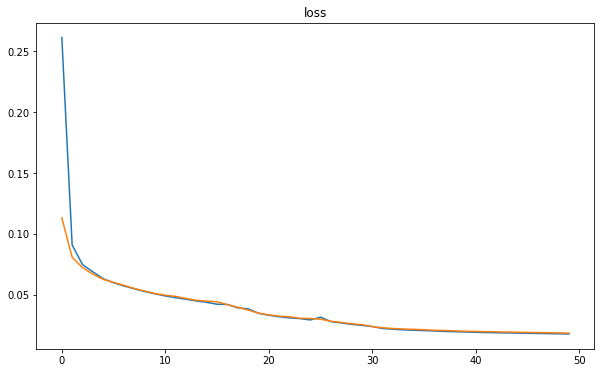

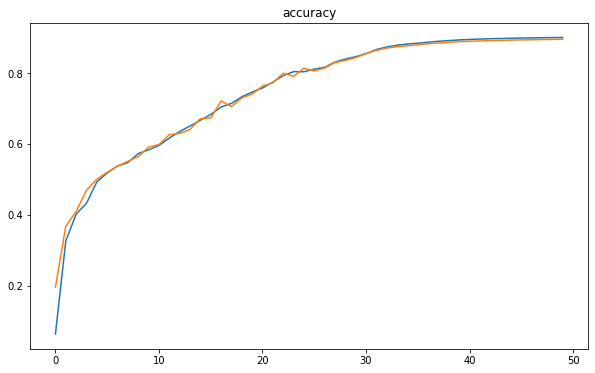

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that her <oov> in all of that have but that <oov> the <oov> is <oov> a very <oov> in in as about <oov> <oov> <oov> <oov> as <oov> other <oov> have <oov> out it <oov> like <oov> <oov> of the <oov> then <oov> <oov> there <oov> and <oov> <oov> <oov> br <oov> <oov> in the <oov> <oov> this is a really bad i that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##Non-Linear Autoencoder for sequences
Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='sigmoid')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='sigmoid'))(encoded)

sequence_autoencoder_LSTM = tf.keras.models.Model(inputs, decoded)

sequence_autoencoder_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder_LSTM.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder_LSTM.fit(X_train_one_hot, X_train_one_hot, epochs=70, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

40/40 - 1s - loss: 0.0019 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


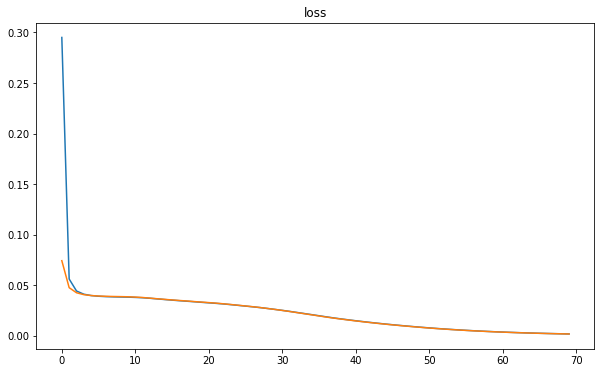

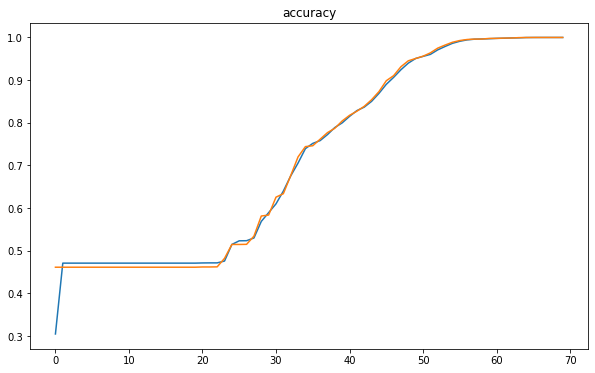

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder_LSTM.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder_LSTM.metrics_names[1], scores[1]*100))

I choose both in the LSTM layer and in the Dense layer the 'sigmoid' activation function and I reach 100% of accuracy. There is a little strange behaviour in the plot because for the first 20 epochs there is no increment in the accuracy. I choose the sigmoid so the output will be a vector containing the probability of a word to correspond to a particular words in the dictionary. To find the word in the dictionary we need to compute the argmax so we will find the index of the word with the highest probability.